# Problem Statement

> **QUESTION**: ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, **you're tasked with creating an automated system to estimate the annual medical expenditure for new customers**, using information such as their age, sex, BMI, children, smoking habits and region of residence.
>
> Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, you must be able to explain why your system outputs a certain prediction.
>
> You're given a [CSV file](https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv) containing verified historical data, consisting of the aforementioned information and the actual medical charges incurred by over 1300 customers.
> <img src="https://i.imgur.com/87Uw0aG.png" width="480">
>
> Dataset source: https://github.com/stedy/Machine-Learning-with-R-datasets

>You can Only Use Linear Regression






In [93]:
!pip install plotly --upgrade

In [94]:
import pandas as pd
import numpy as np
import cufflinks as cf  # Cufflinks is used to show the plotly plot in the Jupyter notebook
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# To show the plotly plot in the Jupyter notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
# Initialize plotly notebook mode
init_notebook_mode(connected=True)
cf.go_offline()
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from urllib.request import urlretrieve
from sklearn.metrics import mean_squared_error, r2_score

In [95]:
medical_charges_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'
urlretrieve(medical_charges_url, 'medical.csv')

('medical.csv', <http.client.HTTPMessage at 0x7dbc107b5b70>)

In [96]:
df=pd.read_csv('medical.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


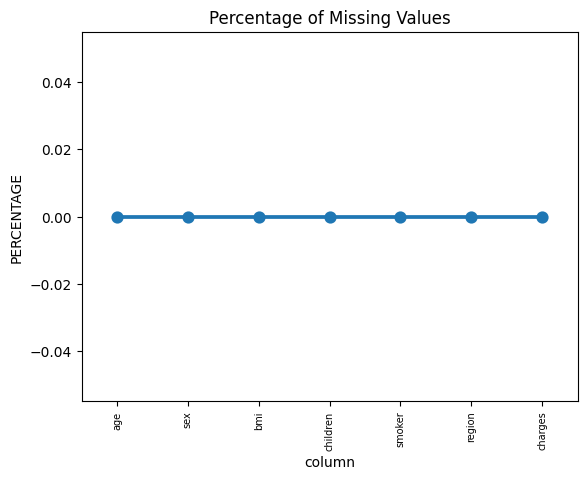

In [98]:
missing = pd.DataFrame((df.isnull().sum()) * 100 / df.shape[0]).reset_index()
missing.columns = ['column', 'percentage']

# Plot the missing values
ax = sns.pointplot(x='column', y='percentage', data=missing)
plt.xticks(rotation=90, fontsize=7)
plt.title("Percentage of Missing Values")
plt.ylabel("PERCENTAGE")
plt.show()

In [99]:
df['region'].value_counts()

,count
region,
southeast,364
southwest,325
northwest,325
northeast,324


In [100]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Skewness in charges

<Axes: xlabel='age', ylabel='Density'>

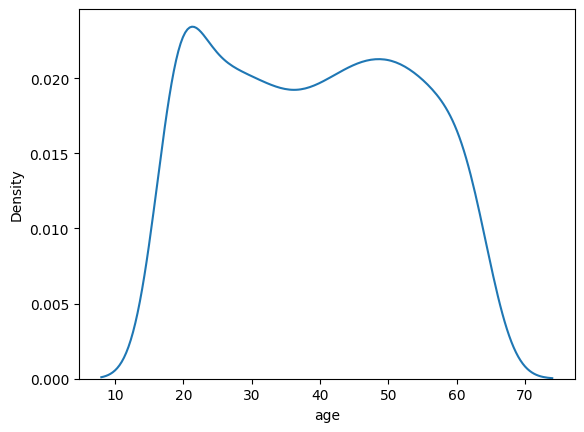

In [101]:
sns.kdeplot(df['age'])

<Axes: ylabel='age'>

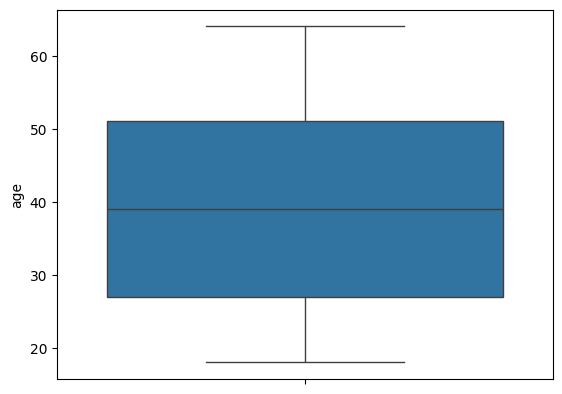

In [102]:
sns.boxplot(df['age'])

<Axes: xlabel='charges', ylabel='Density'>

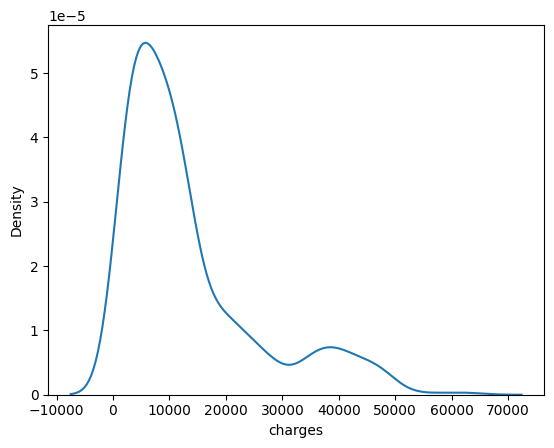

In [103]:
sns.kdeplot(df['charges'])

<Axes: ylabel='charges'>

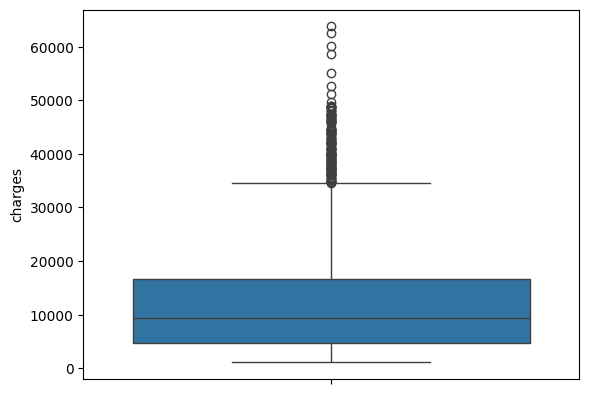

In [104]:
sns.boxplot(df['charges'])

<Axes: xlabel='charges', ylabel='Density'>

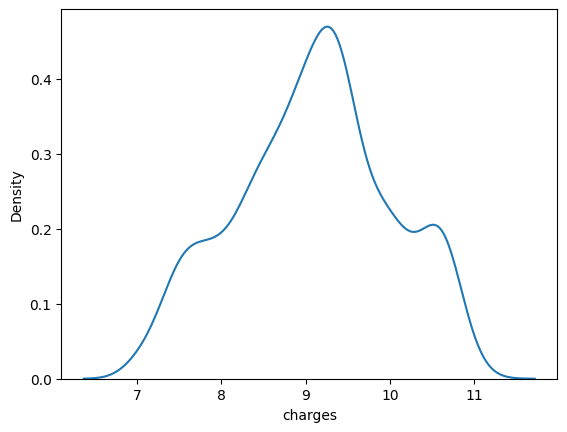

In [105]:
sns.kdeplot(np.log(df['charges']))

<Axes: ylabel='charges'>

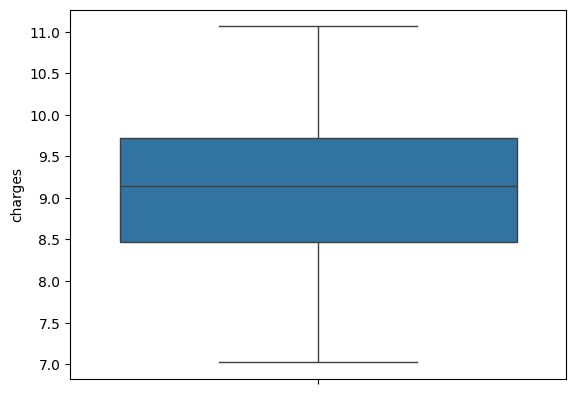

In [106]:
sns.boxplot(np.log(df['charges']))

In [107]:
df['log_charges']=np.log(df['charges'])

In [108]:
def uniplot(df, col, title, hue=None, log_scale=False):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30

    if hue:
        temp = df[hue]
        hue_values = len(temp.unique())
    else:
        temp = pd.Series()
        hue_values = 0

    # Dynamic figure size
    width = len(df[col].unique()) + 7 + 4 * hue_values
    if width > 22:
        width = 22
    fig, ax = plt.subplots()
    fig.set_size_inches(width, 8)

    # Plotting
    plt.xticks(rotation=45)
    if log_scale:
        plt.yscale('log')
    plt.title(title)
    ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, hue=hue, palette='bright')

    plt.show()


In [109]:
df_num=df.select_dtypes(include=['int64','float64'])
df_num.head()

,age,bmi,children,charges,log_charges
0,19,27.900,0,16884.92400,9.734176
1,18,33.770,1,1725.55230,7.453302
2,28,33.000,3,4449.46200,8.400538
3,33,22.705,0,21984.47061,9.998092
4,32,28.880,0,3866.85520,8.260197


In [110]:
df_corr=df_num.corr()
df_corr

,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


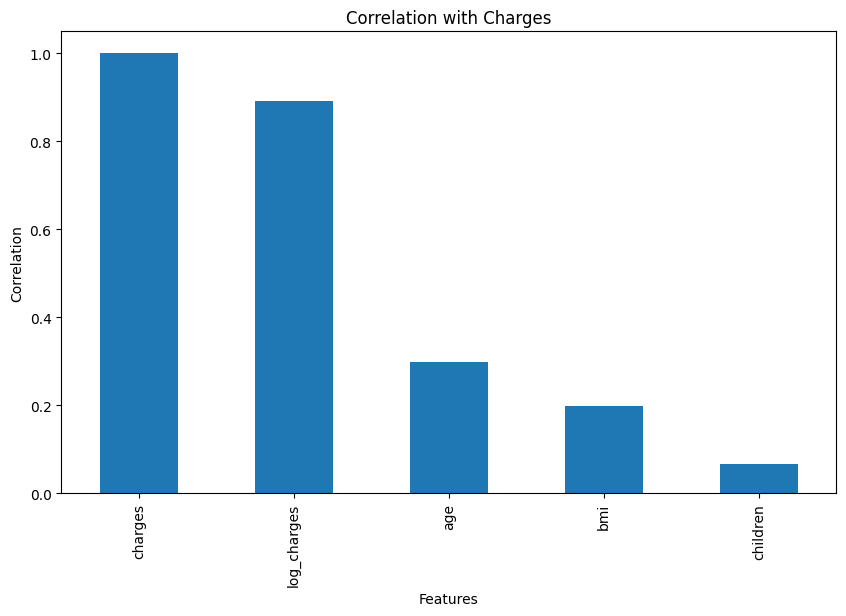

In [111]:
plt.figure(figsize=(10, 6))
df_corr['charges'].sort_values(ascending=False).plot(kind='bar')
plt.title('Correlation with Charges')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

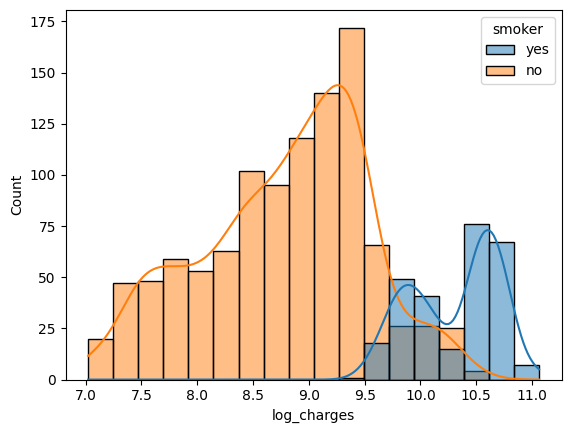

In [112]:
sns.histplot(data=df, x='log_charges', kde=True, hue='smoker')
plt.show()

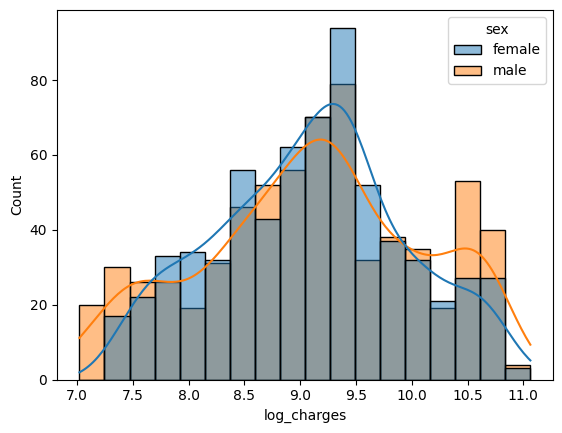

In [113]:
sns.histplot(data=df, x='log_charges', kde=True, hue='sex')
plt.show()

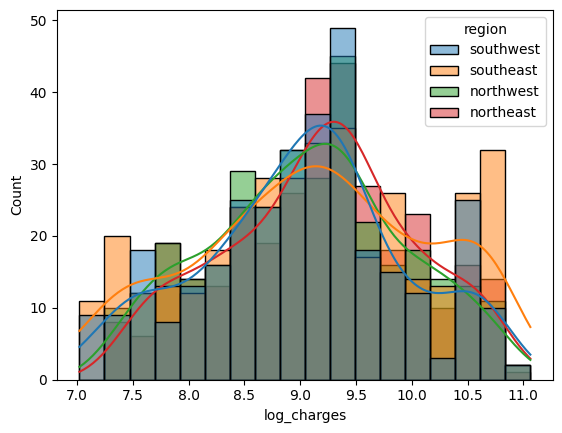

In [114]:
sns.histplot(data=df, x='log_charges', kde=True, hue='region')
plt.show()

In [115]:
df['smoker'].value_counts()

,count
smoker,
no,1064
yes,274


In [116]:
df['sex'].value_counts()

,count
sex,
male,676
female,662


In [117]:
print("Smokers Median :")
print(df[df['smoker'] == 'yes']['charges'].median())
print("Non-Smokers Median :")
print(df[df['smoker'] == 'no']['charges'].median())

print("Male Median :")
print(df[df['sex'] == 'male']['charges'].median())
print("Female Median :")
print(df[df['sex'] == 'female']['charges'].median())
print("Median by Region :")
print("southwest:")
print(df[df['region'] == 'southwest']['charges'].median())
print("southeast:")
print(df[df['region'] == 'southeast']['charges'].median())
print("northwest:")
print(df[df['region'] == 'northwest']['charges'].median())
print("northeast :")
print(df[df['region'] == 'northeast']['charges'].median())



Smokers Median :
34456.348450000005
Non-Smokers Median :
7345.4053
Male Median :
9369.61575
Female Median :
9412.9625
Median by Region :
southwest:
8798.593
southeast:
9294.131949999999
northwest:
8965.79575
northeast :
10057.652025


## Observations

> The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the number of people of any given age (between 18 & 64) in the USA.

> The measurements of body mass index seem to form a Gaussian distribution centered around the value 30

>Northeast has highest Median while southwest is having lowest

>Smokers have higher median

>Females have higher median



<Axes: xlabel='smoker', ylabel='charges'>

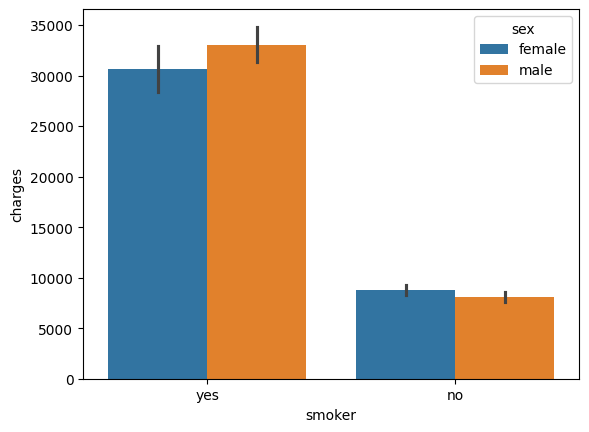

In [118]:
sns.barplot(data=df, x='smoker', hue='sex', y='charges')

<Axes: xlabel='smoker'>

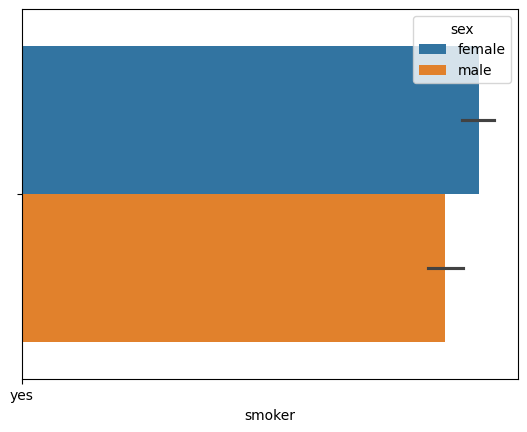

In [119]:
sns.barplot(data=df, x='smoker', hue='sex')

<Axes: xlabel='age', ylabel='charges'>

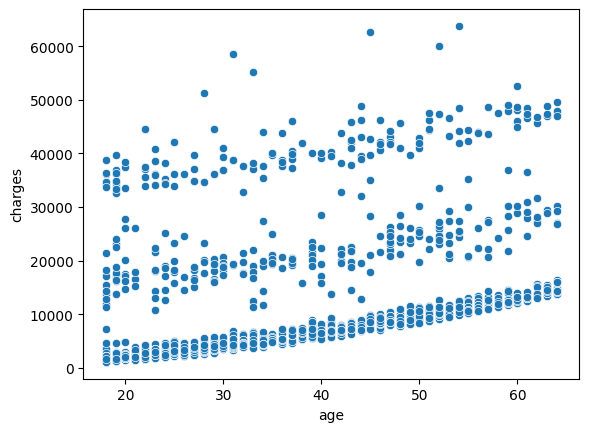

In [120]:
sns.scatterplot(data=df, x='age', y='charges')

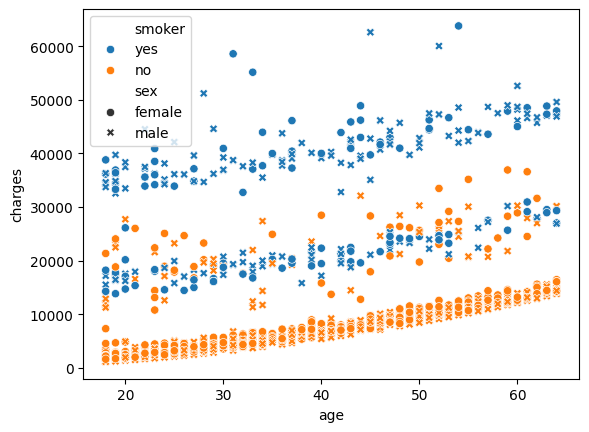

In [121]:
sns.scatterplot(data=df, x='age', y='charges', hue='smoker', style='sex')
plt.show()

We can make the following observations from the above chart:

- The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.

- We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

- The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others

- The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".

- The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.

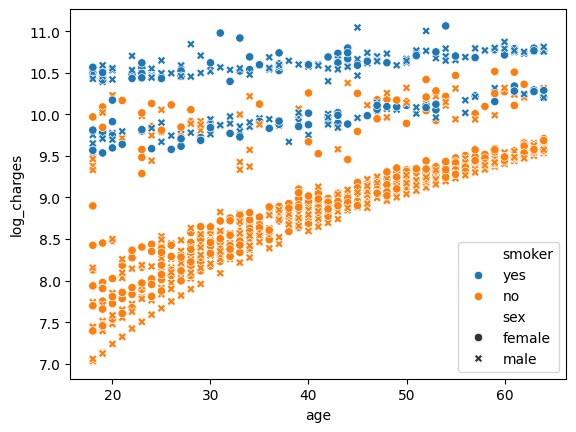

In [122]:
sns.scatterplot(data=df, x='age', y='log_charges', hue='smoker', style='sex')
plt.show()

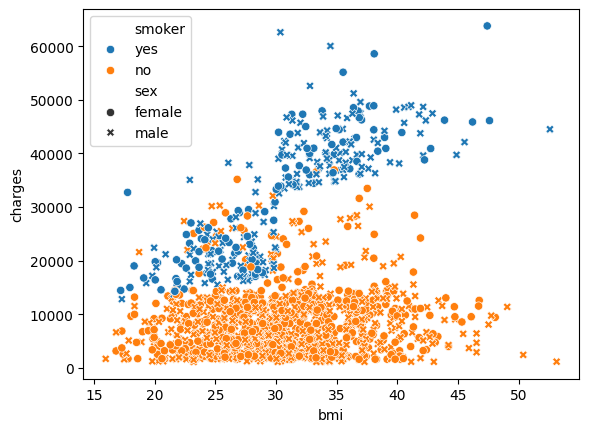

In [123]:
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker', style='sex')
plt.show()

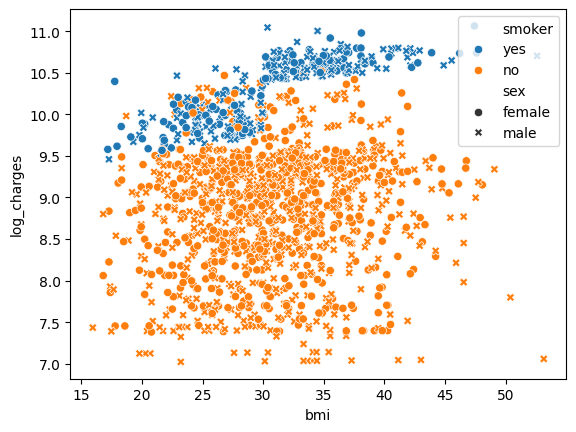

In [124]:
sns.scatterplot(data=df, x='bmi', y='log_charges', hue='smoker', style='sex')
plt.show()

<Axes: xlabel='children', ylabel='charges'>

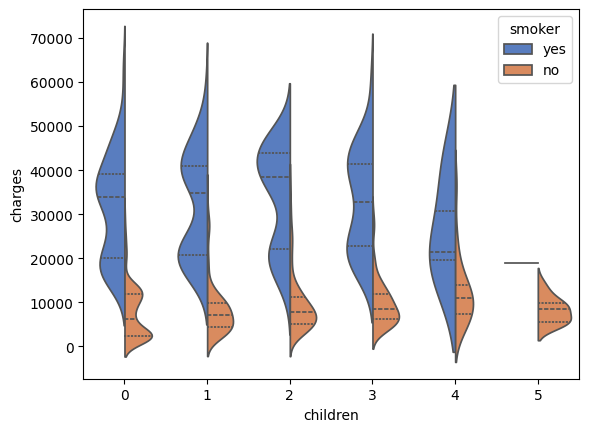

In [125]:
sns.violinplot(data=df, x='children', y='charges', hue='smoker', split=True, inner="quart", palette="muted")


<Axes: xlabel='children', ylabel='log_charges'>

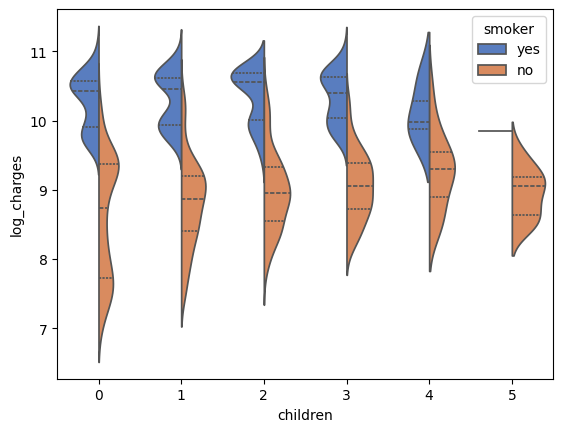

In [126]:
sns.violinplot(data=df, x='children', y='log_charges', hue='smoker', split=True, inner="quart", palette="muted")


<Axes: xlabel='region', ylabel='charges'>

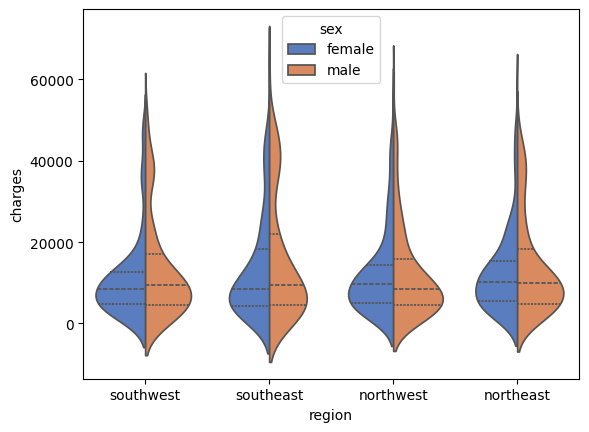

In [127]:
sns.violinplot(data=df, x='region', y='charges', hue='sex', split=True, inner="quart", palette="muted")


<Axes: xlabel='region', ylabel='log_charges'>

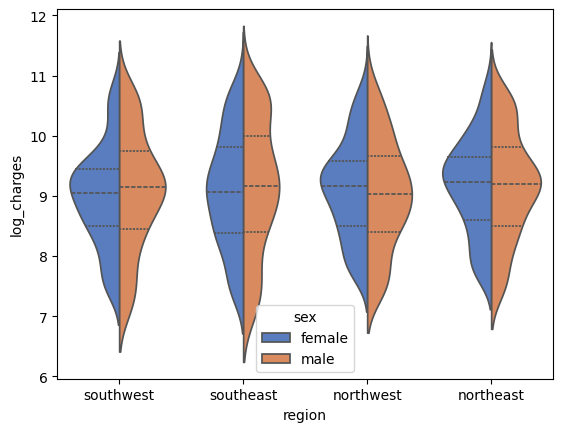

In [128]:
sns.violinplot(data=df, x='region', y='log_charges', hue='sex', split=True, inner="quart", palette="muted")


- People with more childrens are less likely to smoke

-


<Axes: >

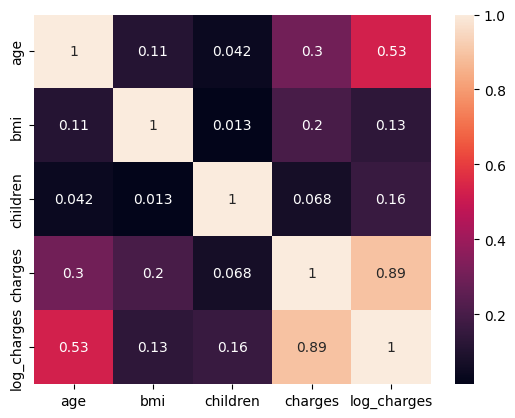

In [129]:
sns.heatmap(df_corr, annot=True)

the logarithmic transformation can make the relationships between variables more linear and reduce the influence of outliers, leading to changes in the correlation coefficients. This is why you observe higher correlations with log(charges) compared to charges.

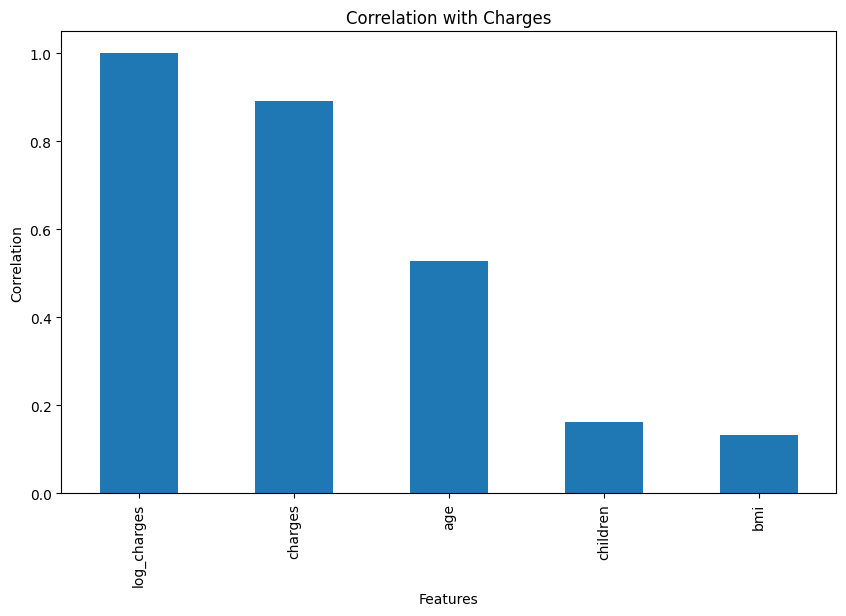

In [130]:
plt.figure(figsize=(10, 6))
df_corr['log_charges'].sort_values(ascending=False).plot(kind='bar')
plt.title('Correlation with Charges')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

In [131]:
df.head()

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176
1,18,male,33.770,1,no,southeast,1725.55230,7.453302
2,28,male,33.000,3,no,southeast,4449.46200,8.400538
3,33,male,22.705,0,no,northwest,21984.47061,9.998092
4,32,male,28.880,0,no,northwest,3866.85520,8.260197


In [132]:
# One-Hot Encoding for 'region'
df = pd.get_dummies(df, columns=['region'], drop_first=True)

# Label Encoding for 'smoker'
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

# Label Encoding for 'sex'
df['sex'] = df['sex'].map({'female': 0, 'male': 1})

df.head()

,age,sex,bmi,children,smoker,charges,log_charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,9.734176,False,False,True
1,18,1,33.770,1,0,1725.55230,7.453302,False,True,False
2,28,1,33.000,3,0,4449.46200,8.400538,False,True,False
3,33,1,22.705,0,0,21984.47061,9.998092,True,False,False
4,32,1,28.880,0,0,3866.85520,8.260197,True,False,False


In [133]:
X = df.drop(columns='charges', axis=1)
X = df.drop(columns='log_charges', axis=1)
y = df['log_charges']

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [135]:

Regressor = LinearRegression()
Regressor.fit(X_train, y_train)



LinearRegression()

In [136]:
y_pred_log = Regressor.predict(X_test)

In [138]:
y_pred = np.exp(y_pred_log)



In [139]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_log))
print('R2 Score:', r2_score(y_test, y_pred_log))

Mean Squared Error: 0.08407695025908977
R2 Score: 0.9064918831305901


In [142]:
import pickle
pickle.dump(Regressor, open('model.pkl','wb'))